In [1]:

import os
import numpy as np
import torch
import math
import cv2
import sys
import time
import argparse
from PIL import Image
import torchvision
from torch import nn, Tensor
from torchvision.transforms import functional as F
from torchvision.transforms import transforms as T
from typing import List, Tuple, Dict, Optional
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
import utils
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
from collections import Counter
from tqdm import tqdm

class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, target):
        for t in self.transforms:
            image, target = t(image, target)
        return image, target


class RandomHorizontalFlip(T.RandomHorizontalFlip):
    def forward(self, image: Tensor,
                target: Optional[Dict[str, Tensor]] = None) -> Tuple[Tensor, Optional[Dict[str, Tensor]]]:
        if torch.rand(1) < self.p:
            image = F.hflip(image)
            if target is not None:
                width, _ = F._get_image_size(image)
                target["boxes"][:, [0, 2]] = width - target["boxes"][:, [2, 0]]
                if "masks" in target:
                    target["masks"] = target["masks"].flip(-1)
                if "keypoints" in target:
                    keypoints = target["keypoints"]
                    keypoints = _flip_coco_person_keypoints(keypoints, width)
                    target["keypoints"] = keypoints
        return image, target

def _flip_coco_person_keypoints(kps, width):
    flip_inds = [0, 2, 1, 4, 3, 6, 5, 8, 7, 10, 9, 12, 11, 14, 13, 16, 15]
    flipped_data = kps[:, flip_inds]
    flipped_data[..., 0] = width - flipped_data[..., 0]
    # Maintain COCO convention that if visibility == 0, then x, y = 0
    inds = flipped_data[..., 2] == 0
    flipped_data[inds] = 0
    return flipped_data

class ToTensor(nn.Module):
    def forward(self, image: Tensor,
                target: Optional[Dict[str, Tensor]] = None) -> Tuple[Tensor, Optional[Dict[str, Tensor]]]:
        image = F.to_tensor(image)
        return image, target

class CustomDataset(object):
    def __init__(self, root, transforms, num=0):
        self.root = root
        self.transforms = transforms
        self.files = os.listdir(os.path.join(root,'Images'))
        #self.sats = np.concatenate([sat,rad[:len(sat)]],axis=1)

        '''
        for i in tqdm(range(len(files))):
            temp = cv2.imread(os.path.join(root,'Images',files[i]))
            temp = temp.astype(np.float32)
            images.append(temp)

            temp = cv2.imread(os.path.join(root,'Masks',files[i][:-3]+'png'))
            masks.append(temp)
        images = np.array(images)
        self.sats = images
        #self.sats = np.transpose(images,(0,2,3,1))
        self.masks = np.array(masks)
        '''
        #print(self.sats.shape)

        #self.sats = self.sats[:100]
        #self.masks = self.masks[:100]
        # ��� �̹��� ���ϵ��� �а�, �����Ͽ�
        # �̹����� ���� ����ũ ������ Ȯ���մϴ�
        #self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        #self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))
        
    def __getitem__(self, idx):
        # �̹����� ����ũ�� �о�ɴϴ�
        #img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        #mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        thrshold = 150
        img = cv2.imread(os.path.join(self.root,'Images',self.files[idx]))
        img = img.astype(np.float32)

        mask = cv2.imread(os.path.join(self.root,'Masks',self.files[idx][:-3]+'png'))
        mask = mask[:,:,0]
        mask[mask <thrshold] = 0
        mask[mask >=thrshold] = 1

        #img = self.sats[idx]
        #mask = self.masks[idx]
        # ���� ����ũ�� RGB�� ��ȯ���� ������ �����ϼ���
        # �ֳ��ϸ� �� ������ �ٸ� �ν��Ͻ��� �ش��ϸ�, 0�� ��濡 �ش��մϴ�
        #mask = Image.open(mask_path)
        # numpy �迭�� PIL �̹����� ��ȯ�մϴ�
        #mask = np.array(mask)
        # �ν��Ͻ����� �ٸ� ����� ���ڵ� �Ǿ� �ֽ��ϴ�.
        obj_ids = np.unique(mask)
        # ù��° id �� ����̶� �����մϴ�
        obj_ids = obj_ids[1:]

        # �÷� ���ڵ��� ����ũ�� ���̳ʸ� ����ũ ��Ʈ�� �����ϴ�
        masks = mask == obj_ids[:, None, None]

        # �� ����ũ�� �ٿ�� �ڽ� ��ǥ�� ����ϴ�
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            if xmin == xmax:
                xmax = xmax+1
            if ymin == ymax :
                ymax = ymax+1
            boxes.append([xmin, ymin, xmax, ymax])

        # ��� ���� torch.Tensor Ÿ������ ��ȯ�մϴ�
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # ��ü ������ �� ������ �����մϴ�(������: ���������� ������� ����Դϴ�)
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        #area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # ��� �ν��Ͻ��� ����(crowd) ���°� �ƴ��� �����մϴ�
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = torch.tensor(100)
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.files)

def get_model_instance_segmentation(num_classes):
    # COCO ���� �̸� �н��� �ν��Ͻ� ���� ���� �о�ɴϴ�
    #model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
    # �з��� ���� �Է� Ư¡ ������ ����ϴ�
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # �̸� �н��� ����� ���ο� ������ �ٲߴϴ�
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # ����ũ �з��⸦ ���� �Է� Ư¡���� ������ ����ϴ�
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # ����ũ �����⸦ ���ο� ������ �ٲߴϴ�
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

def get_transform(train):
    transforms = []
    transforms.append(ToTensor())
    return Compose(transforms)


def train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq):
    model.train()
    metric_logger = utils.MetricLogger(delimiter="  ")
    metric_logger.add_meter('lr', utils.SmoothedValue(window_size=1, fmt='{value:.6f}'))
    header = 'Epoch: [{}]'.format(epoch)

    lr_scheduler = None
    if epoch == 0:
        warmup_factor = 1. / 1000
        warmup_iters = min(1000, len(data_loader) - 1)

        lr_scheduler = utils.warmup_lr_scheduler(optimizer, warmup_iters, warmup_factor)

    for images, targets in metric_logger.log_every(data_loader, print_freq, header):
        images = list(image.to(device) for image in images)
        target = [{k: v.to(device) for k, v in t.items()} for t in targets]

        if target[0]['boxes'].size()[0]==0 :
            continue
        
        loss_dict = model(images, target)

        losses = sum(loss for loss in loss_dict.values())
        # reduce losses over all GPUs for logging purposes
        loss_dict_reduced = utils.reduce_dict(loss_dict)
        losses_reduced = sum(loss for loss in loss_dict_reduced.values())

        loss_value = losses_reduced.item()

        if not math.isfinite(loss_value):
            print("Loss is {}, stopping training".format(loss_value))
            print(loss_dict_reduced)
            sys.exit(1)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if lr_scheduler is not None:
            lr_scheduler.step()

        metric_logger.update(loss=losses_reduced, **loss_dict_reduced)
        metric_logger.update(lr=optimizer.param_groups[0]["lr"])

    return metric_logger

#set root
data_path = "/home/jini1114/git/MODNet/data"
model_path = "/home/jini1114/git/MODNet/model"
#Origin_path = '/mnt/nasmnt/sat'

# �н��� GPU�� �����ϵ� GPU�� �������� ������ CPU�� �մϴ�
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# �츮 �����ͼ��� �� ���� Ŭ������ �����ϴ� - ���� ���
num_classes = 2
# �����ͼ°� ���ǵ� ��ȯ���� ����մϴ�
dataset = CustomDataset(data_path, get_transform(train=True))

# �����ͼ��� �н���� �׽�Ʈ������ �����ϴ�(������: ���⼭�� ��ü�� 50���� �׽�Ʈ��, �������� �н��� ����մϴ�)

#dataset = torch.utils.data.Subset(dataset, list(range(int(len(dataset)*0.8))))
#dataset_test = torch.utils.data.Subset(dataset, list(range(int(len(dataset)*0.8),len(dataset))))
'''
indices = torch.randperm(len(dataset)).tolist()
dataset_test = torch.utils.data.Subset(dataset, indices[8:])
'''
# ������ �δ��� �н���� ���������� �����մϴ�
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=16, shuffle=True, num_workers=2,
    collate_fn=utils.collate_fn)
'''
data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=16, shuffle=False, num_workers=2,
    collate_fn=utils.collate_fn)
    '''
# ���� �Լ��� �̿��� ���� �����ɴϴ�
model = get_model_instance_segmentation(num_classes)

# ���� GPU�� CPU�� �ű�ϴ�
model.to(device)



MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256)
          (relu): ReLU(inplace=True)
          (downsample): 

In [3]:

# ��Ƽ������(Optimizer)�� ����ϴ�
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)
# �н��� �����췯�� ����ϴ�
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                   
                                                 step_size=3,
                                                gamma=0.1)

# 10 ����ũ��ŭ �н��غ��ô�
num_epochs = 1
print_freq = 1

for epoch in range(num_epochs):
    # 1 ����ũ���� �н��ϰ�, 10ȸ ���� ����մϴ�
    model.train()
    metric_logger = utils.MetricLogger(delimiter="  ")
    metric_logger.add_meter('lr', utils.SmoothedValue(window_size=1, fmt='{value:.6f}'))
    header = 'Epoch: [{}]'.format(epoch)

    lr_scheduler = None
    if epoch == 0:
        warmup_factor = 1. / 1000
        warmup_iters = min(1000, len(data_loader) - 1)

        lr_scheduler = utils.warmup_lr_scheduler(optimizer, warmup_iters, warmup_factor)

    for images, targets in metric_logger.log_every(data_loader, print_freq, header):
        images = list(image.to(device) for image in images)
        target = [{k: v.to(device) for k, v in t.items()} for t in targets]

        if target[0]['boxes'].size()[0]==0 :
            continue
        
        loss_dict = model(images, target)

        losses = sum(loss for loss in loss_dict.values())
        # reduce losses over all GPUs for logging purposes
        loss_dict_reduced = utils.reduce_dict(loss_dict)
        losses_reduced = sum(loss for loss in loss_dict_reduced.values())

        loss_value = losses_reduced.item()

        if not math.isfinite(loss_value):
            print("Loss is {}, stopping training".format(loss_value))
            print(loss_dict_reduced)
            sys.exit(1)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if lr_scheduler is not None:
            lr_scheduler.step()

        metric_logger.update(loss=losses_reduced, **loss_dict_reduced)
        metric_logger.update(lr=optimizer.param_groups[0]["lr"])

    # �н����� ������Ʈ �մϴ�
    lr_scheduler.step()
    # �׽�Ʈ �����ͼ¿��� �򰡸� �մϴ�



/usr/anaconda3/envs/hair_task/lib/python3.6/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/usr/anaconda3/envs/hair_task/lib/python3.6/site-packages/torchvision/ops/boxes.py:101: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  keep = keep.nonzero().squeeze(1)


Epoch: [0]  [   0/1735]  eta: 0:53:13  lr: 0.000010  loss: 252.2971 (252.2971)  loss_classifier: 43.5754 (43.5754)  loss_box_reg: 1.3147 (1.3147)  loss_mask: 204.8627 (204.8627)  loss_objectness: 1.6964 (1.6964)  loss_rpn_box_reg: 0.8478 (0.8478)  time: 1.8405  data: 0.5814  max mem: 12274
Epoch: [0]  [   1/1735]  eta: 0:42:04  lr: 0.000015  loss: 125.6378 (188.9674)  loss_classifier: 1.4438 (22.5096)  loss_box_reg: 0.3638 (0.8393)  loss_mask: 118.5406 (161.7016)  loss_objectness: 1.6964 (3.3688)  loss_rpn_box_reg: 0.2485 (0.5482)  time: 1.4558  data: 0.2945  max mem: 12546
Epoch: [0]  [   2/1735]  eta: 0:39:01  lr: 0.000020  loss: 125.6378 (140.6550)  loss_classifier: 1.4438 (15.2074)  loss_box_reg: 0.4596 (0.7127)  loss_mask: 118.5406 (120.9821)  loss_objectness: 2.6957 (3.1444)  loss_rpn_box_reg: 0.7288 (0.6084)  time: 1.3513  data: 0.2225  max mem: 12546
Epoch: [0]  [   3/1735]  eta: 0:37:00  lr: 0.000025  loss: 60.3173 (120.5706)  loss_classifier: 0.6031 (11.5066)  loss_box_reg: 0

SystemExit: 1

/usr/anaconda3/envs/hair_task/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3351: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [8]:
import matplotlib.pyplot as plt


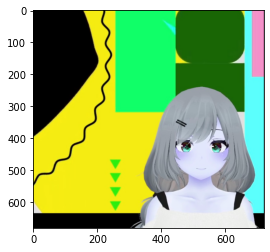

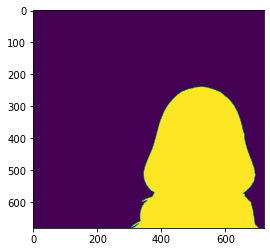

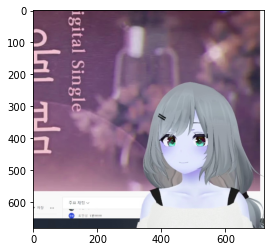

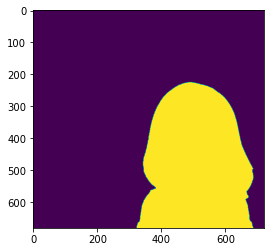

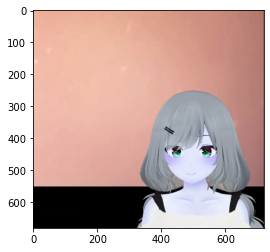

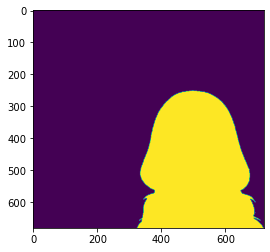

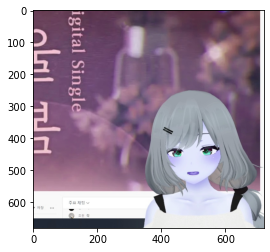

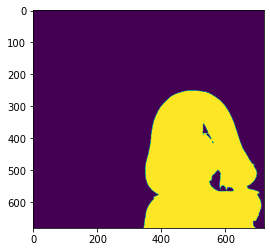

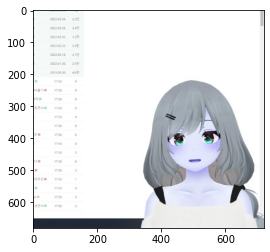

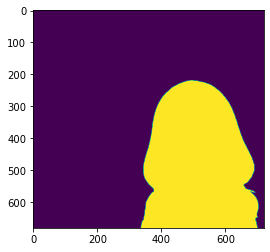

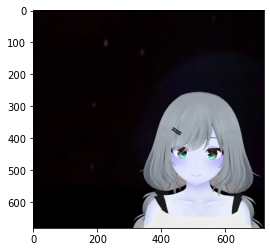

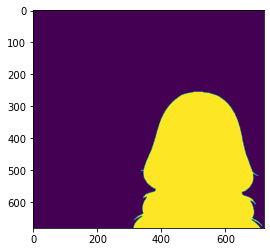

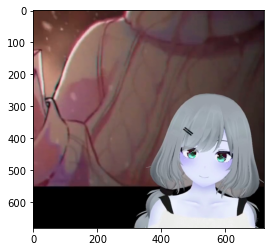

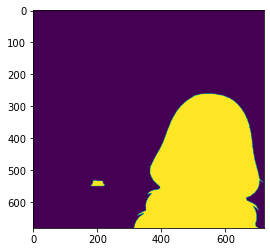

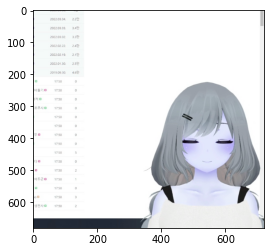

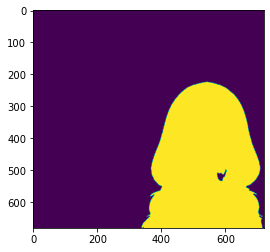

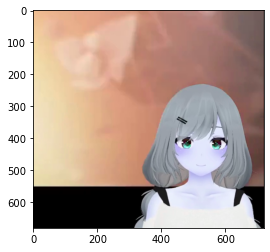

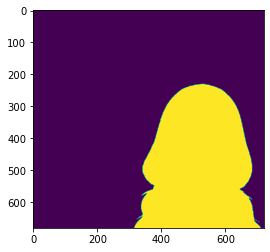

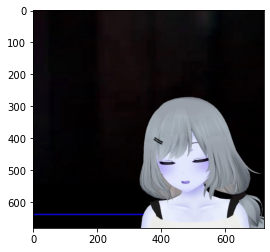

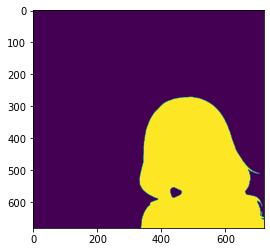

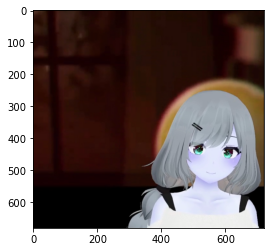

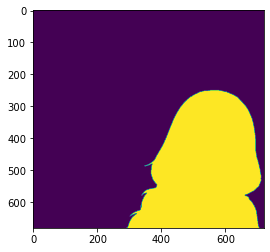

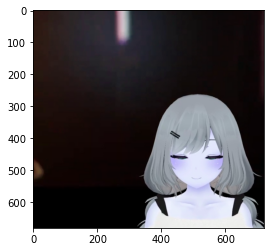

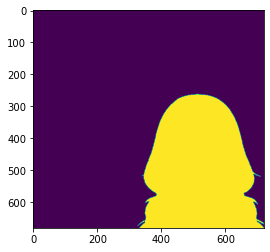

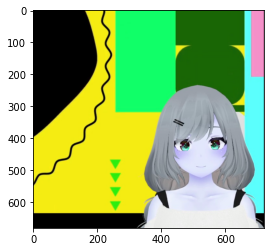

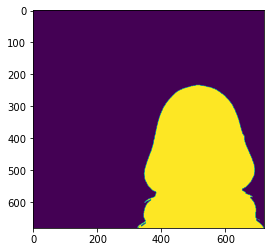

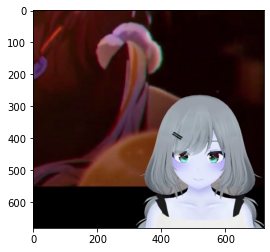

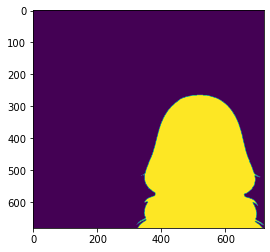

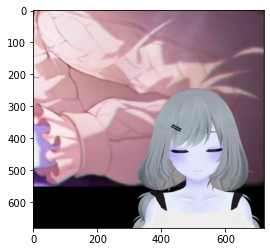

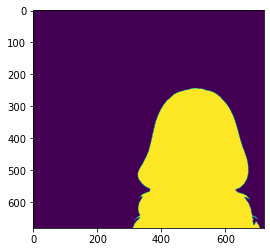

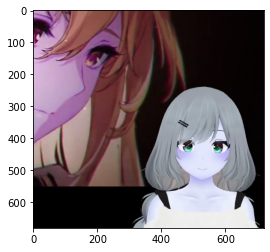

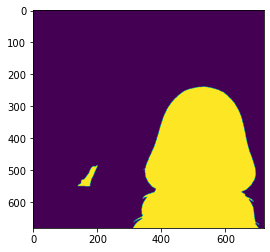

In [25]:
for i in range(len(images)):

    temp_image = images[i]
    temp_target = targets[i]['masks']
    plt.imshow(temp_image.detach().cpu().numpy().transpose((1,2,0)).astype(np.uint8))
    plt.show()
    plt.imshow(temp_target.detach().cpu().numpy().transpose((1,2,0)))
    plt.show()

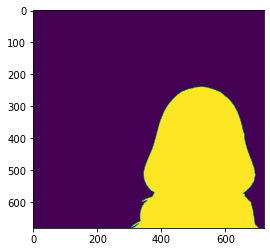

In [17]:

temp_target = targets[0]['masks']
plt.imshow(temp_target.detach().cpu().numpy().transpose((1,2,0)))
plt.show()

In [ ]:
plt.imshow(temp_image.detach().cpu().numpy().transpose((1,2,0)))

In [16]:
temp_target['masks']

tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8)

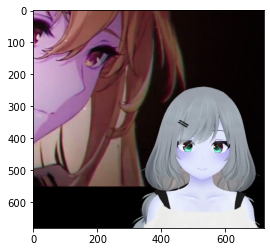

In [28]:
plt.imshow(temp_image.detach().cpu().numpy().transpose((1,2,0))/255)